# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://www.ramp.studio/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rampwf.utils.importing import import_module_from_source
pd.set_option('display.max_columns', None)

In [2]:
# !pip install -U seaborn  # if you don't have it, or pip3 for python3

In [3]:
# optional
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

First we load `problem.py` that parameterizes the challenge. It contains some objects taken off the shelf from `ramp-workflow` (e.g., `Predictions` type, scores, and data reader). 

In [4]:
problem = import_module_from_source('problem.py', 'problem')

`get_train_data` loads the training data and returns an `pandas` object (input) and a `np.array` object (output).

In [5]:
dat = pd.read_csv('data/train.csv.bz2')

X_df = dat.drop(columns='log_PAX')

y_array = dat['log_PAX'].values

In [6]:
X_df, y_array = problem.get_train_data()

In [7]:
print(min(X_df['DateOfDeparture']))
print(max(X_df['DateOfDeparture']))

2011-09-01
2013-03-05


In [8]:
X_df.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [9]:
X_df['Departure'].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

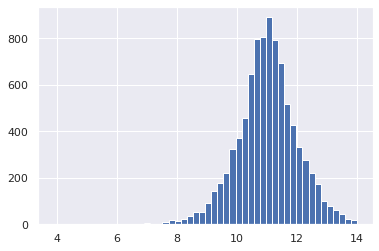

In [10]:
plt.hist(y_array, bins=50);

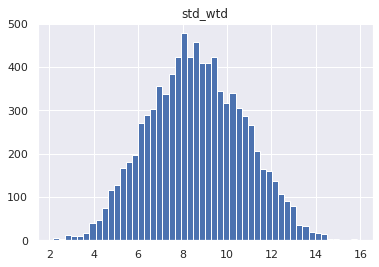

In [11]:
X_df.hist('std_wtd', bins=50);

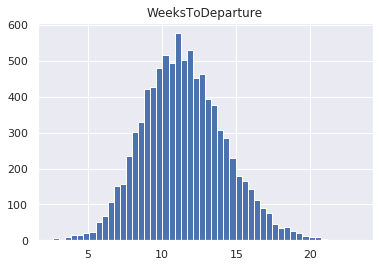

In [12]:
X_df.hist('WeeksToDeparture', bins=50);

In [13]:
X_df.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [14]:
X_df.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
std_wtd             float64
dtype: object

In [15]:
X_df.shape

(8902, 5)

In [16]:
print(y_array.mean())
print(y_array.std())

10.99904767212102
0.9938894125318564


## Preprocessing dates

Getting dates into numerical columns is a common operation when time series data is analyzed with non-parametric predictors. The code below makes the following transformations:

- numerical columns for year (2011-2012), month (1-12), day of the month (1-31), day of the week (0-6), and week of the year (1-52)
- number of days since 1970-01-01

In [17]:
X_encoded = X_df

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

In [18]:
X_encoded.tail(5)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days
8897,2011-10-02,DTW,ATL,9.263158,7.316967,2011,10,2,6,39,15249
8898,2012-09-25,DFW,ORD,12.772727,10.641034,2012,9,25,1,39,15608
8899,2012-01-19,SFO,LAS,11.047619,7.908705,2012,1,19,3,3,15358
8900,2013-02-03,ORD,PHL,6.076923,4.030334,2013,2,3,6,5,15739
8901,2011-11-26,DTW,ATL,9.526316,6.167733,2011,11,26,5,47,15304


We will perform all preprocessing steps within a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html) which chains together tranformation and estimator steps. This offers offers convenience and safety (help avoid leaking statistics from your test data into the trained model in cross-validation) and the whole pipeline can be evaluated with `cross_val_score`.

To perform the above encoding within a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html) we will a function and using `FunctionTransformer` to make it compatible with scikit-learn API.

In [30]:
from sklearn.preprocessing import FunctionTransformer

def _encode_dates(X):

    # to avoid SettingwithCopyWarning
    X_encoded = X.copy()
    X_encoded.loc[:, 'year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded.loc[:, 'day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    
    return X_encoded

date_transformer = FunctionTransformer(_encode_dates, validate=False)

## Linear regressor

Preprocessing for linear regressor includes one-hot encoding non-ordinal categorical variables. We will use
[`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) to [`OneHotEncode`](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features) the categorical variables and drop the `DateOfDeparture` feature.

In [31]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['Departure', 'Arrival', 'year', 'month', 'day', 'weekday', 'week']
drop_cols = ['DateOfDeparture']

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('drop', drop_cols),
    remainder='passthrough'
)

We can now combine our `preprocessor` with the `LinearRegression` estimator in a `Pipeline`:

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    date_transformer, preprocessor, LinearRegression()
)

We can cross-validate our `pipeline` using `cross_val_score`. Below we will have specified `cv=5` meaning KFold cross-valdiation splitting will be used, with 8 folds. The mean squared error regression loss is calculated for each split. The output `score` will be an array of 5 scores from each KFold. The score mean and standard deviation of the 5 scores is printed at the end.

In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X_df, y_array, cv=5, scoring='neg_mean_squared_error')

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6288 +/- 0.0192


## Random Forests

One-hot encoding of our categorical features is not required, nor recommended for tree based estimators so we will amend our `preprocessor` to use `OrdinalEncoder` instead.

Technically, the numerical values of the date columns (e.g., `month`, `day`) are already ordinally encoded and performing `OrdinalEncoder` is simply a style preference as it will map the values starting from 0.

In [23]:
from sklearn.preprocessing import OrdinalEncoder

categorical_cols = ['Departure', 'Arrival', 'year', 'month', 'day', 'weekday', 'week']
drop_cols = ['DateOfDeparture']

preprocessor = make_column_transformer(
    (OrdinalEncoder(), categorical_cols),
    ('drop', drop_cols),
    remainder='passthrough'
)

In [24]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 10
max_depth = 10
max_features = 10

pipeline = make_pipeline(
    date_transformer, preprocessor,
    RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
)

In [25]:
scores = cross_val_score(pipeline, X_df, y_array, cv=5, scoring='neg_mean_squared_error')
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

/home/lucy/miniconda3/envs/rampwf/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/lucy/miniconda3/envs/rampwf/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/lucy/miniconda3/envs/rampwf/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

RMSE: 0.6286 +/- 0.0204


# Merging external data

The objective in this RAMP data challenge is to find good data that can be correlated to flight traffic. We will use some weather data (saved in `submissions/starting_kit`) to provide an example of how to merge external data in a scikit-learn pipeline.

Your external data will need to be included in your submissions folder - see [RAMP submissions](#RAMP-submissions) for more details.

First we will define a function that merges the external data to our feature data.

In [28]:
 filepath = os.path.join(os.path.dirname(__file__),
                            'external_data.csv')

In [29]:
filepath

'submissions/external_data.csv'

In [26]:
# we need this because the global variable __file__ (the path of the current file)
# does not exist if we are in a notebook
__file__ = 'submissions/starting_kit'

def _merge_external_data(X):
    filepath = os.path.join(os.path.dirname(__file__),
                            'external_data.csv')
    data_weather = pd.read_csv(filepath)
    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
    X_merged = pd.merge(
        X, X_weather, how='left', on=['DateOfDeparture', 'Arrival'], sort=False
    )
    return X_merged

Double check that our function works:

In [27]:
_merge_external_data(X_df).head()

FileNotFoundError: [Errno 2] File b'submissions/external_data.csv' does not exist: b'submissions/external_data.csv'

Use `FunctionTransformer` to make our function compatible with scikit-learn API:

In [ ]:
merge_transformer = FunctionTransformer(_merge_external_data, validate=False)

We can now assemble our pipeline using the same `date_transformer` and `preprocessor` as above:

In [ ]:
n_estimators = 10
max_depth = 10
max_features = 10

pipeline = make_pipeline(
    merge_transformer, date_transformer, preprocessor,
    RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
)

In [ ]:
scores = cross_val_score(pipeline, X_df, y_array, cv=5, scoring='neg_mean_squared_error')
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

## Variable importances

To investigate the relative importance of each feature we can use the `feature_importances_` method of the final estimator after we `fit` it.

Note that `reg[-1]` subsets the final tuple ('step') of the pipeline and `reg[-1][1]` subsets the second item (the `RandomForestRegressor`) of the final tuple.

Below we will plot feature importance, ordered from most important to least important:

In [ ]:
reg = pipeline.fit(X_df, y_array)

In [ ]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg[-1][1].feature_importances_)[::-1]

importances = reg[-1][1].feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x - 0.2, feature_names, rotation=45, fontsize=15);

## RAMP submissions

For submitting to the [RAMP site](http://ramp.studio), you will need to create a `estimator.py` file that defines a `get_estimator` function which returns a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

For example, to submit our last example above, we would define our `pipeline` within the function and return the pipeline at the end. Remember to include all the necessary imports at the beginning of the file.

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor


def _merge_external_data(X):
    X.loc[:, 'DateOfDeparture'] = pd.to_datetime(X.loc[:, 'DateOfDeparture'])
    filepath = os.path.join(
        os.path.dirname(__file__), 'external_data.csv'
    )
    data_weather = pd.read_csv(filepath, parse_dates=["Date"])
    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'}
    )
    X_merged = pd.merge(
        X, X_weather, how='left', on=['DateOfDeparture', 'Arrival'], sort=False
    )
    return X_merged


def _encode_dates(X):
    X.loc[:, 'year'] = X['DateOfDeparture'].dt.year
    X.loc[:, 'month'] = X['DateOfDeparture'].dt.month
    X.loc[:, 'day'] = X['DateOfDeparture'].dt.day
    X.loc[:, 'weekday'] = X['DateOfDeparture'].dt.weekday
    X.loc[:, 'week'] = X['DateOfDeparture'].dt.week
    X.loc[:, 'n_days'] = X['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    return X


def get_estimator():
    merge_transformer = FunctionTransformer(_merge_external_data)
    date_transformer = FunctionTransformer(_encode_dates)

    categorical_cols = ['Arrival', 'Departure']
    drop_col = ['DateOfDeparture']
    preprocessor = make_column_transformer(
        (OrdinalEncoder(), categorical_cols),
        ('drop', drop_col),
        remainder='passthrough'
    )
    pipeline = make_pipeline(
        merge_transformer, date_transformer, preprocessor,
        RandomForestRegressor(n_estimators=10, max_depth=10, max_features=10)
    )
    return pipeline


If you take a look at the sample submission in the directory `submissions/starting_kit`, you will find a file named `estimator.py`, which includes the same code as above.

You can test that the sample submission works by running `ramp_test_submission` in your terminal (ensure that `ramp-workflow` has been installed and you are in the `air_passenger` ramp kit directory). Alternatively, you can also run `ramp_test_submission` with a notebook by adding `!` at the beginning:

In [ ]:
!ramp_test_submission

To create a new submission you can either amend the files within `submissions/starting_kit` or create a new folder within `submissions`, naming it anythin you like, and save our `estimator.py` file within the new folder.

### External data

Your external data needs to be saved with your `estimator.py`. For example the sample suubmission directory (`submissions/starting_kit`) contains a `estimator.py` file and the external data file `external_data_mini.csv`. Ensure that you amend your code to match the name of the external data file.

### Local testing

You can test that your submission works locally by running:

`ramp_test_submission --submission <folder>`

where `<folder>` is the name of the new folder you created, within `submissions`.

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>.

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good solution, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then, find the appropriate open event for the [titanic](http://www.ramp.studio/events/air_passengers) challenge. Sign up for the event. Note that both RAMP and event signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request(s) have been accepted, you can go to your [sandbox](http://www.ramp.studio/events/air_passengers/sandbox) and copy-paste (or upload) your `submissions.py` file. Save your submission, name it, then click 'submit'. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/air_passengers/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/air_passengers/leaderboard).

If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/air_passengers/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.748 ± 0.0117
valid rmse = 0.858 ± 0.0111
test rmse = 0.881 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the leaderboard is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.858 ± 0.0111`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=air passengers notebook).